In [2]:
import numpy as np
from tqdm import tqdm
import email
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Data preparation:-

In [3]:
# loading the final email dataset after all the cleaning is done
Final_Data=pickle.load(open("../input/final-preprocessed-data-case-study2/emails_df_final_2606.pkl","rb"))

In [4]:
Final_Data.shape

(210450, 3)

In [5]:
Final_Data.head()

,mail_content,mail_content_len,clean_mail_content
1,Traveling to have a business meeting takes the...,786,traveling to have a business meeting takes the...
3,"Randy,\n\n Can you send me a schedule of the s...",187,"randy, can you send me a schedule of the salar..."
5,"Greg,\n\n How about either next Tuesday or Thu...",59,"greg, how about either next tuesday or thursda..."
6,Please cc the following distribution list with...,242,please cc the following distribution list with...
8,1. login: pallen pw: ke9davis\n\n I don't thi...,224,. login pallen pw ke davis i don't think these...


In [6]:
Final_Data.drop(["mail_content","mail_content_len"],axis=1,inplace=True)

In [7]:
Final_Data.head()

,clean_mail_content
1,traveling to have a business meeting takes the...
3,"randy, can you send me a schedule of the salar..."
5,"greg, how about either next tuesday or thursda..."
6,please cc the following distribution list with...
8,. login pallen pw ke davis i don't think these...


In [13]:
Final_Data.shape

(210450, 1)

In [14]:
Final_Data['clean_mail_content_len'] = Final_Data['clean_mail_content'].apply(lambda x:len(nltk.word_tokenize(x)))

In [15]:
Final_Data=Final_Data[Final_Data["clean_mail_content_len"]<=20]

In [16]:
Final_Data=pickle.load(open("../input/final-preprocessed-data-case-study2/Final_Data.pkl","rb"))

In [17]:
Final_Data.head()

,clean_mail_content,clean_mail_content_len
5,"greg, how about either next tuesday or thursda...",11
9,,0
29,nymex expiration is during this time frame. pl...,11
36,"greg, happy b day. email me your phone and i w...",17
62,"ina, i scheduled a meeting with jean mrha tomo...",11


In [21]:
Final_Data.shape

(19069, 2)

# performing the train test split

In [22]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(Final_Data,test_size=0.15,random_state=12)

In [24]:
print("train dataset size {}".format(train.shape))
print("test dataset size {}".format(test.shape))

train dataset size (16208, 2)
test dataset size (2861, 2)


In [25]:
train.head()

,clean_mail_content,clean_mail_content_len
450018,scott sitter bear paw energy crestone energy v...,15
59306,fyi. in case you're interested.,8
64206,please forward your schedules for this week to...,17
512416,"http www.hoovers.com industry snapshot , , , ....",8
497171,"fyi, this is for petro and misako.",9


In [26]:
test.head()

,clean_mail_content,clean_mail_content_len
40597,image image image to unsubscribe from the emai...,14
252777,"bob, please activate some new henry hub gas da...",18
275413,what was the name of that chop house restauran...,12
300624,i can never get both of your email addresses r...,15
494646,are you there yet? mark mcconnell transwestern...,15


# Preparing the data for train dataset

In [27]:
output=[]
for i in tqdm(train["clean_mail_content"].values):
    token_list=i.split()
    for j in range(len(token_list)-1):
        data = []
        x_ngram = '<start> ' + ' '.join(token_list[:j+1]) + ' <end>'
        y_ngram = '<start> ' + ' '.join(token_list[j+1:]) + ' <end>'
        data.append(x_ngram)
        data.append(y_ngram)
        output.append(data)
Final_Train_df = pd.DataFrame(output, columns=['input','output'])

100%|██████████| 16208/16208 [00:01<00:00, 13735.07it/s]


In [28]:
Final_Train_df.head()

,input,output
0,<start> scott <end>,<start> sitter bear paw energy crestone energy...
1,<start> scott sitter <end>,<start> bear paw energy crestone energy ventur...
2,<start> scott sitter bear <end>,"<start> paw energy crestone energy ventures, l..."
3,<start> scott sitter bear paw <end>,"<start> energy crestone energy ventures, l.l.c..."
4,<start> scott sitter bear paw energy <end>,"<start> crestone energy ventures, l.l.c. ph fa..."


In [31]:
Final_Train_df.shape

(179685, 2)

In [29]:
output=[]
for i in tqdm(test["clean_mail_content"].values):
    token_list=i.split()
    for j in range(len(token_list)-1):
        data = []
        x_ngram = '<start> ' + ' '.join(token_list[:j+1]) + ' <end>'
        y_ngram = '<start> ' + ' '.join(token_list[j+1:]) + ' <end>'
        data.append(x_ngram)
        data.append(y_ngram)
        output.append(data)
Final_Test_df = pd.DataFrame(output, columns=['input','output'])

100%|██████████| 2861/2861 [00:00<00:00, 42658.89it/s]


In [32]:
Final_Test_df.shape

(31107, 2)

In [30]:
Final_Test_df.head()

,input,output
0,<start> image <end>,<start> image image to unsubscribe from the em...
1,<start> image image <end>,<start> image to unsubscribe from the email li...
2,<start> image image image <end>,"<start> to unsubscribe from the email list, cl..."
3,<start> image image image to <end>,"<start> unsubscribe from the email list, click..."
4,<start> image image image to unsubscribe <end>,"<start> from the email list, click here image ..."


In [33]:
print("train dataset shape",Final_Train_df.shape)
print("test dataset shape",Final_Test_df.shape)

train dataset shape (179685, 2)
test dataset shape (31107, 2)


In [34]:
%%time
Final_Train_df['input_len'] = Final_Train_df['input'].apply(lambda x:len(nltk.word_tokenize(x)))
Final_Test_df['input_len'] = Final_Test_df['input'].apply(lambda x:len(nltk.word_tokenize(x)))

CPU times: user 38 s, sys: 23 ms, total: 38 s
Wall time: 38.1 s


In [35]:
Final_Train_df.head()

,input,output,input_len
0,<start> scott <end>,<start> sitter bear paw energy crestone energy...,7
1,<start> scott sitter <end>,<start> bear paw energy crestone energy ventur...,8
2,<start> scott sitter bear <end>,"<start> paw energy crestone energy ventures, l...",9
3,<start> scott sitter bear paw <end>,"<start> energy crestone energy ventures, l.l.c...",10
4,<start> scott sitter bear paw energy <end>,"<start> crestone energy ventures, l.l.c. ph fa...",11


In [36]:
Final_Test_df.head()

,input,output,input_len
0,<start> image <end>,<start> image image to unsubscribe from the em...,7
1,<start> image image <end>,<start> image to unsubscribe from the email li...,8
2,<start> image image image <end>,"<start> to unsubscribe from the email list, cl...",9
3,<start> image image image to <end>,"<start> unsubscribe from the email list, click...",10
4,<start> image image image to unsubscribe <end>,"<start> from the email list, click here image ...",11


In [37]:
print("train dataset shape",Final_Train_df.shape)
print("test dataset shape",Final_Test_df.shape)

train dataset shape (179685, 3)
test dataset shape (31107, 3)


# Removing the all the sentences have more than 20 words

In [38]:
%%time
Final_Train_df=Final_Train_df[Final_Train_df["input_len"]<20]
Final_Test_df=Final_Test_df[Final_Test_df["input_len"]<20]

CPU times: user 15.9 ms, sys: 994 µs, total: 16.9 ms
Wall time: 15.9 ms


In [39]:
print("final train dataset shape",Final_Train_df.shape)
print("final test dataset shape",Final_Test_df.shape)

final train dataset shape (157315, 3)
final test dataset shape (27262, 3)


# Tokenization of train and test data

In [40]:
tokenizer_train_ip = Tokenizer(filters='')
tokenizer_train_ip.fit_on_texts(Final_Train_df["input"].values)

In [41]:
word_index_train_ip = tokenizer_train_ip.word_index
vocab_size_train_ip=len(word_index_train_ip)+1
print("input vocab size {}".format(vocab_size_train_ip))

input vocab size 16029


In [42]:
train_text_sequences_ip = tokenizer_train_ip.texts_to_sequences(Final_Train_df["input"].values)
test_text_sequences_ip = tokenizer_train_ip.texts_to_sequences(Final_Test_df["input"].values)

In [43]:
Train_padded_data_ip = pad_sequences(train_text_sequences_ip, padding='post',maxlen=20)
print(Train_padded_data_ip)

[[   1  273    2 ...    0    0    0]
 [   1  273 5853 ...    0    0    0]
 [   1  273 5853 ...    0    0    0]
 ...
 [   1   83   70 ...    0    0    0]
 [   1   83   70 ...    0    0    0]
 [   1   83   70 ...    0    0    0]]


In [44]:
Test_padded_data_ip = pad_sequences(test_text_sequences_ip, padding='post',maxlen=20)
print(Test_padded_data_ip)

[[   1  156    2 ...    0    0    0]
 [   1  156  156 ...    0    0    0]
 [   1  156  156 ...    0    0    0]
 ...
 [   1    8  895 ...    0    0    0]
 [   1    8  895 ...    0    0    0]
 [   1 3599    2 ...    0    0    0]]


In [45]:
print("train data shape after padding",Train_padded_data_ip.shape)
print("test data shape after padding",Test_padded_data_ip.shape)

train data shape after padding (157315, 20)
test data shape after padding (27262, 20)


# Output class label tokenization

In [46]:
tokenizer_train_op = Tokenizer(filters='')
tokenizer_train_op.fit_on_texts(Final_Train_df["output"].values)

In [47]:
word_index_train_op = tokenizer_train_op.word_index
vocab_size_train_op=len(word_index_train_op)+1
print("output vocab size {}".format(vocab_size_train_op))

output vocab size 19214


In [48]:
train_text_sequences_op = tokenizer_train_op.texts_to_sequences(Final_Train_df["output"].values)
test_text_sequences_op = tokenizer_train_op.texts_to_sequences(Final_Test_df["output"].values)

In [49]:
Train_padded_data_op = pad_sequences(train_text_sequences_op, padding='post',maxlen=20)
print(Train_padded_data_op)

[[    1 18362  2999 ...     0     0     0]
 [    1  2999  3940 ...     0     0     0]
 [    1  3940   237 ...     0     0     0]
 ...
 [    1    29     4 ...     0     0     0]
 [    1     4  9952 ...     0     0     0]
 [    1  9952  1164 ...     0     0     0]]


In [50]:
Test_padded_data_op = pad_sequences(test_text_sequences_op, padding='post',maxlen=20)
print(Test_padded_data_ip)

[[   1  156    2 ...    0    0    0]
 [   1  156  156 ...    0    0    0]
 [   1  156  156 ...    0    0    0]
 ...
 [   1    8  895 ...    0    0    0]
 [   1    8  895 ...    0    0    0]
 [   1 3599    2 ...    0    0    0]]


In [51]:
print("output train data shape after padding",Train_padded_data_op.shape)
print(" output test data shape after padding",Test_padded_data_op.shape)

output train data shape after padding (157315, 20)
 output test data shape after padding (27262, 20)


# Model Building

In [72]:
input_layer = tf.keras.Input(shape=(20,))

Emded_layer = tf.keras.layers.Embedding(vocab_size_train_ip, 300, input_length=20)(input_layer)

dense_layer1 = tf.keras.layers.LSTM(128,return_sequences=True)(Emded_layer)

dropout_layer1 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_layer1')(dense_layer1)

dense_layer2 = tf.keras.layers.Dense(350,activation='relu', kernel_initializer=tf.keras.initializers.he_normal, name = 'Dense_layer2')(dropout_layer1)

dropout_layer2 = tf.keras.layers.Dropout(rate = 0.4 , name = 'dropout_layer2')(dense_layer2)

dense_layer3 = tf.keras.layers.Dense(350,activation='relu', kernel_initializer=tf.keras.initializers.he_normal ,name = 'Dense_layer3')(dropout_layer2)

output = tf.keras.layers.Dense(vocab_size_train_op,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal , name = 'output')(dense_layer3)

model = tf.keras.Model(inputs= input_layer, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 300)           4808700   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 128)           219648    
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 20, 128)           0         
_________________________________________________________________
Dense_layer2 (Dense)         (None, 20, 350)           45150     
_________________________________________________________________
dropout_layer2 (Dropout)     (None, 20, 350)           0         
_________________________________________________________________
Dense_layer3 (Dense)         (None, 20, 350)           122850

In [74]:
def perplexity(y_true, y_pred):
    """
    this function will calculate perplexity metric for train and test dataset
    """
    return keras.backend.exp(keras.backend.mean(keras.backend.sparse_categorical_crossentropy(y_true, y_pred)))

# Compiling the model

In [73]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[perplexity])

# Fitting the data to train dataset

In [75]:
history = model.fit(Train_padded_data_ip, Train_padded_data_op, epochs=20, validation_data=(Test_padded_data_ip,Test_padded_data_ip) , batch_size=512)

Epoch 1/20
308/308 [==============================] - 40s 125ms/step - loss: 3.2066 - perplexity: 136.7309 - val_loss: 3.1685 - val_perplexity: 24.1397
Epoch 2/20
308/308 [==============================] - 38s 124ms/step - loss: 2.8282 - perplexity: 16.9623 - val_loss: 3.4526 - val_perplexity: 32.3221
Epoch 3/20
308/308 [==============================] - 38s 124ms/step - loss: 2.6313 - perplexity: 13.9227 - val_loss: 3.5547 - val_perplexity: 35.6841
Epoch 4/20
308/308 [==============================] - 38s 124ms/step - loss: 2.4728 - perplexity: 11.8763 - val_loss: 3.8351 - val_perplexity: 47.3928
Epoch 5/20
308/308 [==============================] - 38s 124ms/step - loss: 2.3635 - perplexity: 10.6495 - val_loss: 3.8889 - val_perplexity: 50.0786
Epoch 6/20
308/308 [==============================] - 38s 124ms/step - loss: 2.2922 - perplexity: 9.9131 - val_loss: 3.8708 - val_perplexity: 48.8537
Epoch 7/20
308/308 [==============================] - 38s 124ms/step - loss: 2.2394 - perplexi

# plotting the graph for loss and perplexity for both train and test dataset

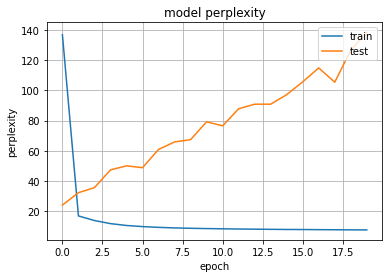

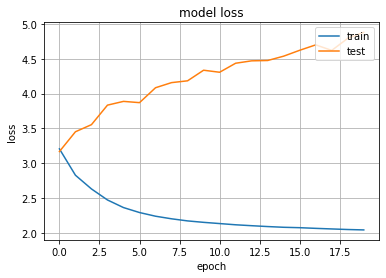

In [76]:
import matplotlib.pyplot as plt
# perplexity for Simple LSTM model
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()
# Loss for Simple LSTM model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()


In [77]:
output_vocab = tokenizer_train_op.word_index
new_output_vocab = dict([(value, key) for key, value in output_vocab.items()])

# preparing the pipeline for final prediction

In [78]:
def model_predict(text):
    '''this function will predict the the text sequence based on given input sequence'''
    Y_pred_test=model.predict(text.reshape(-1,20))
    y_hat=[]
    pred_words=[]
    for j in Y_pred_test[0]:
        y_hat.append(np.argmax(j))
    for k in y_hat:
        if k!=0:
            pred_words.append(new_output_vocab[k])
            
    return (' '.join(pred_words))
    

# Calculating the bleu score 

In [80]:
from nltk.translate.bleu_score import sentence_bleu
test_sample = Final_Test_df.sample(16000)
final_bleu_score = []
for i in tqdm(range(16000)):
    actual  = test_sample["input"].values[i]
    test_input = tokenizer_train_ip.texts_to_sequences([str(test_sample["input"].values[i])])
    test_input = pad_sequences(test_input, padding="post",maxlen= 20)
    Predict = model_predict(test_input)
    final_bleu_score.append(sentence_bleu([actual.split(),], Predict.split()))
print("final bleu score of model {}".format(np.mean(final_bleu_score)))

100%|██████████| 16000/16000 [11:13<00:00, 23.77it/s]

final bleu score of model 0.4237378035570082


# Summary of above trained first cut LSTM model

In [81]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable([ "Model","perplexity score on test data", "Bleu Score"])
  
# Add rows
myTable.add_row(["LSTM","138.4", "0.42"])
               
print(myTable)

+-------+-------------------------------+------------+
| Model | perplexity score on test data | Bleu Score |
+-------+-------------------------------+------------+
|  LSTM |             138.4             |    0.42    |
+-------+-------------------------------+------------+


# Observations:-

1. From above result we can say that simple lstm based model is not performing well as it has perlexity of 138 which is very high and bleu of 0.4 which is also not that good.